# Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# The Data

The data set used in this study was sourced from Hadi Fanaee-T at the Laboratory of Artificial Intelligence and Decision Support (LIAAD), University of Porto, and INESC Porto, Campus da FEUP. 

The original data was obtained from the Capital Bikeshare website, which is a new generation of traditional bike rentals where the whole process from membership, rental and return back has become automatic. 

The data set contains information about bike-sharing programs around the world composed of over 500,000 bicycles. 

This data set is interesting for research due to its real-world applications and the characteristics of the data generated by these systems. 

Unlike other transportation services such as buses or subways, the duration of travel, departure and arrival position is explicitly recorded in these systems, which turns bike sharing systems into a virtual sensor network that can be used for sensing mobility in the city. 

This data set can be used to monitor the city's mobility and detect important events.

Relevant papers related to this data set include "Event labeling combining ensemble detectors and background knowledge" by Fanaee-T and Gama, and a citation request is available for this data set.

### Variables:

- instant: record index
- dteday : date
- season : season (1 : winter, 2 : spring, 3 : summer, 4 : fall)
- yr : year (0: 2011, 1 : 2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit :
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t - t_min)/(t_max - t_min), t_min = -8, t_max = +39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [2]:
df = pd.read_csv("hour.csv")
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


# Variable selection

In [3]:
independent_variables = [

    'season',
    'yr',
    'mnth',
    'hr',
    'holiday',
    'weekday',
    'workingday',
    'weathersit',
    'temp',
    'hum',
    'windspeed',
    'casual',
    'registered'
    
]

dependent_variable = ['cnt']

y = df[dependent_variable]
X = df[independent_variables]

# Preprocessing

The 'dteday' needs to be encoded so that we can group by days

In [4]:
le = LabelEncoder()

df['dteday'] = df['dteday'].astype(str)
le.fit(df['dteday'])
df['dteday'] = le.transform(df['dteday'])

# EDA

### Descriptive statistics

In [5]:
summary_table = pd.concat([X.describe(), y.describe()], axis = 1)
summary_table

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### Correlations Matrix

In [6]:
correlation_matrix = X.corr()
correlation_matrix

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered
season,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.150625,-0.149773,0.120206,0.174226
yr,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,-0.083546,-0.008740,0.142779,0.253684
mnth,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.164411,-0.135386,0.068457,0.122273
hr,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,-0.276498,0.137252,0.301202,0.374141
holiday,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.010588,0.003988,0.031564,-0.047345
weekday,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.037158,0.011502,0.032721,0.021578
workingday,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.015688,-0.011830,-0.300942,0.134326
weathersit,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,0.418130,0.026226,-0.152628,-0.120966
temp,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,-0.069881,-0.023125,0.459616,0.335361
hum,0.150625,-0.083546,0.164411,-0.276498,-0.010588,-0.037158,0.015688,0.418130,-0.069881,1.000000,-0.290105,-0.347028,-0.273933


### Variance-Covariance Matrix

In [7]:
var_cov_matrix = X.cov()
var_cov_matrix

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered
season,1.225268,-0.005946,3.160817,-0.046817,-0.001774,-0.005185,0.007080,-0.010279,0.066506,0.032167,-0.020282,6.560463,29.189784
yr,-0.005946,0.250008,-0.018007,-0.013369,0.000559,-0.004498,-0.000511,-0.006124,0.003939,-0.008059,-0.000535,3.519905,19.198785
mnth,3.160817,-0.018007,11.825178,-0.137239,0.010595,0.071733,-0.005565,0.011871,0.133551,0.109078,-0.056957,11.606863,63.641093
hr,-0.046817,-0.013369,-0.137239,47.808998,0.000554,-0.048509,0.007354,-0.089311,0.183207,-0.368847,0.116102,102.684174,391.555310
holiday,-0.001774,0.000559,0.010595,0.000554,0.027944,-0.034230,-0.019643,-0.001821,-0.000880,-0.000341,0.000082,0.260150,-1.197919
weekday,-0.005185,-0.004498,0.071733,-0.048509,-0.034230,4.023119,0.033566,0.004246,-0.000693,-0.014379,0.002822,3.235972,6.550791
workingday,0.007080,-0.000511,-0.005565,0.007354,-0.019643,0.033566,0.216626,0.013293,0.004964,0.001409,-0.000674,-6.906050,9.462757
weathersit,-0.010279,-0.006124,0.011871,-0.089311,-0.001821,0.004246,0.013293,0.408777,-0.012636,0.051577,0.002051,-4.811367,-11.705993
temp,0.066506,0.003939,0.133551,0.183207,-0.000880,-0.000693,0.004964,-0.012636,0.037078,-0.002596,-0.000545,4.363584,9.774015
hum,0.032167,-0.008059,0.109078,-0.368847,-0.000341,-0.014379,0.001409,0.051577,-0.002596,0.037222,-0.006847,-3.301074,-7.999213


# Visualizations

Distribution of Dates

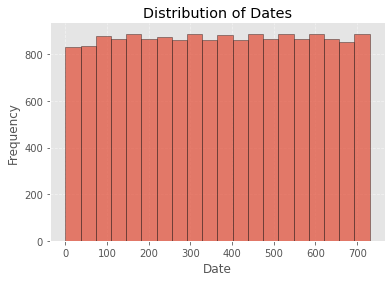

In [8]:
# Set style
plt.style.use('ggplot')

# Plot the frequencies of X
fig, ax = plt.subplots()
ax.hist(df['dteday'], bins=20, alpha=0.7, edgecolor='black')

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Dates')

# Add grid and customize spines
ax.grid(True, linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
plt.show()


Bike Sharing Count by Date

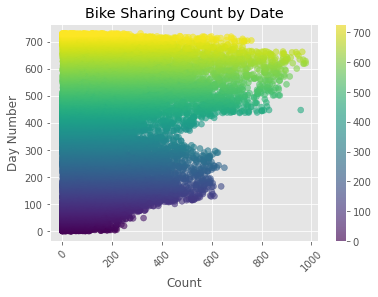

In [9]:
# Set the color map
cmap = plt.get_cmap('viridis')

# Plot the relationship between X and y
plt.scatter(y, df['dteday'], c=df['dteday'], cmap=cmap, alpha=0.6)

# Set the x-axis label and tick labels
plt.xlabel('Count')
plt.xticks(rotation=45)

# Set the y-axis label and tick labels
plt.ylabel('Day Number')

# Set the plot title
plt.title('Bike Sharing Count by Date')

# Add a color bar legend
cbar = plt.colorbar()
cbar.set_label('')

# Show the plot
plt.show()


Distribution of Bike Sharing by Month

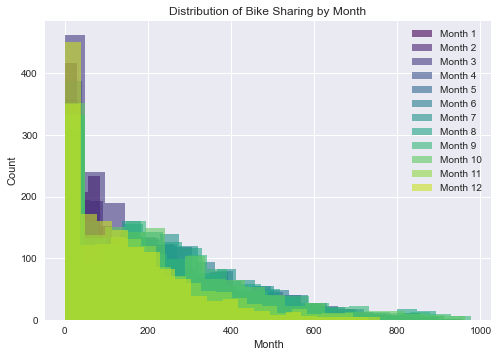

In [10]:
# Set style
plt.style.use('seaborn')

# Set color map
cmap = plt.get_cmap('viridis')

# Get unique months
unique_months = sorted(X['mnth'].unique())

# Create a color list for each month
colors = [cmap(i/len(unique_months)) for i in range(len(unique_months))]

# Create a figure and axes object
fig, ax = plt.subplots()

# Plot the month distribution of cnt
for i, month in enumerate(unique_months):
    month_data = y[X['mnth']==month]
    ax.hist(month_data, bins=20, alpha=0.6, color=colors[i], label='Month {}'.format(month))

# Set axis labels and title
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_title('Distribution of Bike Sharing by Month')

# Add legend
ax.legend()

# Show the plot
plt.show()


Distribution of Bike Sharing by Hour

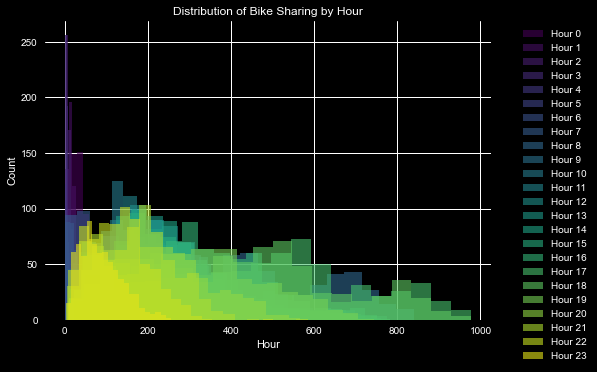

In [11]:
# Set style
plt.style.use('dark_background')

# Set color map
cmap = plt.get_cmap('viridis')

# Get unique hours
unique_hours = sorted(X['hr'].unique())

# Create a color list for each hour
colors = [cmap(i/len(unique_hours)) for i in range(len(unique_hours))]

# Create a figure and axes object
fig, ax = plt.subplots()

# Plot the month distribution of cnt
for i, hour in enumerate(unique_hours):
    hour_data = y[X['hr']==hour]
    ax.hist(hour_data, bins=20, alpha=0.6, color=colors[i], label='Hour {}'.format(hour))

# Set axis labels and title
ax.set_xlabel('Hour')
ax.set_ylabel('Count')
ax.set_title('Distribution of Bike Sharing by Hour')

# Add legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


Temperature & Bike Sharing

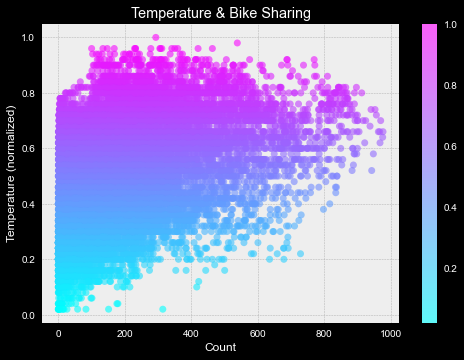

In [12]:
# Set style
plt.style.use('bmh')

# Set color map
cmap = plt.get_cmap('cool')

# Create a figure and axes object
fig, ax = plt.subplots()

# Plot the temperature distribution of cnt
sc = ax.scatter(y, X['temp'], c=X['temp'], cmap=cmap, alpha=0.6, edgecolors='none')

# Set axis labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Temperature (normalized)')
ax.set_title('Temperature & Bike Sharing')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('')

# Show the plot
plt.show()


Humidity & Bike Sharing

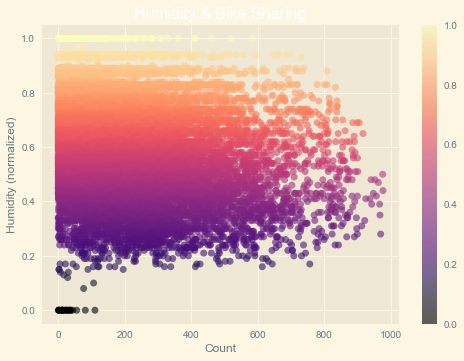

In [13]:
# Set style
plt.style.use('Solarize_Light2')

# Set color map
cmap = plt.get_cmap('magma')

# Create a figure and axes object
fig, ax = plt.subplots()

# Plot the temperature distribution of cnt
sc = ax.scatter(y, X['hum'], c=X['hum'], cmap=cmap, alpha=0.6, edgecolors='none')

# Set axis labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Humidity (normalized)')
ax.set_title('Humidity & Bike Sharing')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('')

# Show the plot
plt.show()


Wind speed & Bike Sharing

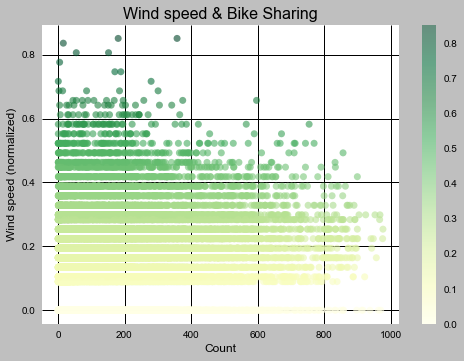

In [14]:
# Set style
plt.style.use('grayscale')

# Set color map
cmap = plt.get_cmap('YlGn')

# Create a figure and axes object
fig, ax = plt.subplots()

# Plot the temperature distribution of cnt
sc = ax.scatter(y, X['windspeed'], c=X['windspeed'], cmap=cmap, alpha=0.6, edgecolors='none')

# Set axis labels and title
ax.set_xlabel('Count')
ax.set_ylabel('Wind speed (normalized)')
ax.set_title('Wind speed & Bike Sharing')

# Add colorbar
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel('')

# Show the plot
plt.show()


### Split the data into train & test sets: 70/30

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

# Building the model

In [16]:
mlp = MLPRegressor(random_state = 42)

### Define hyperparameters and perform grid search with cross-validation

In [17]:
param_grid = {

    'hidden_layer_sizes': [(10,), (50,), (100,)], 
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': [0.001, 0.01, 0.1]

    }

# 
grid = GridSearchCV(mlp, param_grid = param_grid, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)

c:\Users\adana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, estimator=MLPRegressor(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'alpha': [0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(10,), (50,), (100,)]})

### The best hyperparameters

In [18]:
print("Best hyperparameters: ", grid.best_params_)

Best hyperparameters:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,)}


### Train the model on the optimal hyperparameters

In [19]:
mlp = MLPRegressor(activation = 'relu', alpha = 0.1, hidden_layer_sizes = (50, ))
mlp.fit(X_train, y_train)

c:\Users\adana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(alpha=0.1, hidden_layer_sizes=(50,))

# Performance Metrics

### Test set predictions

In [20]:
y_pred_test = mlp.predict(X_test)

### Mean Squared Error

In [21]:
mse = mean_squared_error(y_test, y_pred_test)

print(f"MSE = {mse}")

MSE = 0.011963824199267552


### R-Squared

In [22]:
r2 = r2_score(y_test, y_pred_test)

print(f"R2 score = {r2}")

R2 score = 0.9999996212881991


### Predicted vs actual values; perfect accuracy

c:\Users\adana\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


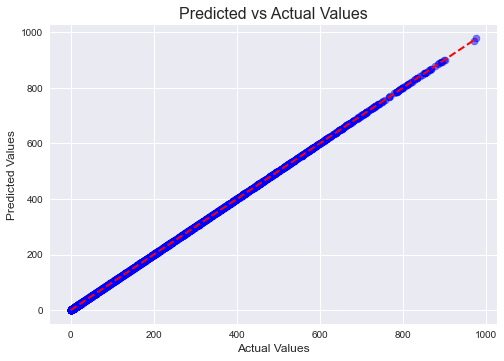

In [23]:
# Set plot style
sns.set_style("darkgrid")

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred_test, alpha=0.5, color='blue')

# Add a diagonal line for reference
plt.plot([0, y_test.max()], [0, y_test.max()], linestyle='--', color='red')

# Set axis labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")

# Show the plot
plt.show()

### Learning curve

We see that the model is not overfitting the data

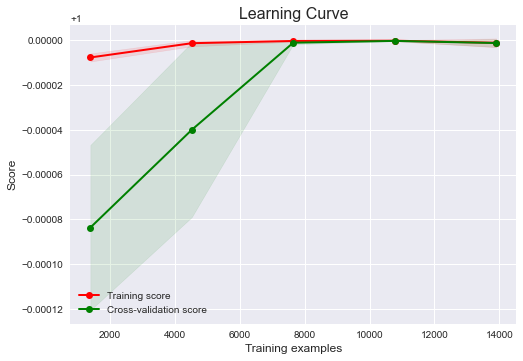

In [24]:
train_sizes, train_scores, test_scores = learning_curve(mlp, X, y, cv = 5, n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 5))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve")
plt.show()

# Summing Up

All predictions

In [25]:
y_pred = mlp.predict(X)

results_df = pd.DataFrame(
    {
        'Date': df['dteday'],
        'Predicted Bike Sharing': y_pred
    }
)

results_df

,Date,Predicted Bike Sharing
0,0,15.972929
1,0,39.985683
2,0,32.005997
3,0,13.035249
4,0,1.016245
...,...,...
17374,730,119.080144
17375,730,89.070907
17376,730,90.075091
17377,730,61.248091


In [26]:
results_df.to_csv("Results.csv", index = False)

# Thanks for reading